In [1]:
# imports

import os
import os.path
import cv2
import glob
import h5py
import tqdm
import argparse
import logging
from PIL import Image 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme()
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import sys
sys.path.append('../')
import data, utils, models

In [2]:
# EXAMPLE NUMBER
example = 0 # Set 1 for another example

In [3]:
# necessary variable deifnitons

parallel = True
Fast = False
pretrained = True
old = True
load_opt = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = transforms.Compose([transforms.ToPILImage()])
to_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1)])
center = transforms.Compose([transforms.CenterCrop(40)])

dataset = "CFC"
video = f"Elwha_2018_OM_ARIS_2018_07_09_2018-07-09_190000_490_941"
patch_size = 256
stride = 128
is_image = False
n_frames = 5
cpf = 1
mid = n_frames // 2
is_real = True

aug = 3

dist = 'G'
mode = 'S'
noise_std = 30
min_noise = 0
max_noise = 100

batch_size = 1
lr = 1e-4

In [4]:
# load model

PATH = "/root/SAVeD/checkpoints/udvd/checkpoint_best.pt"

model, optimizer, args = utils.load_model(PATH, parallel=parallel, pretrained=pretrained, old=old, load_opt=load_opt)
model.to(device)
print(model)

BlindVideoNet(
  (rotate): rotate()
  (denoiser_1): Blind_UNet(
    (enc1): ENC_Conv(
      (conv1): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv2): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv3): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (pool): Pool(
        (shift): shift(
       

In [6]:
# data loader

PATH = "/root/Data/CFC22/udvd_frames/raw/elwha"
train_loader, test_loader = data.build_dataset("CFC", PATH, batch_size=1, image_size=None)

In [7]:
# denoise

model.eval()

if example == 0:
    num = 18; x = 575; y = 475; w = 200; h = 200
elif example == 1:
    num = 100; x = 442; y = 886; w = 128; h = 128

# with torch.no_grad():
#     inputs = test_loader.dataset[num].unsqueeze(0)[:,:,y:y+h, x:x+w].to(device)
#     outputs, _ = model(inputs)

with torch.no_grad():
    print(len(test_loader.dataset))
    noisy_inputs = test_loader.dataset[num]
    noisy_inputs = noisy_inputs.to(device)

    noisy_inputs_with_batch = noisy_inputs.unsqueeze(0)
    
    outputs, est_sigma = model(noisy_inputs_with_batch)
    noisy_frame = noisy_inputs_with_batch[:, (mid * cpf):((mid + 1) * cpf), :, :]

451


(1256, 632)
False
-0.046666443
1.0365529


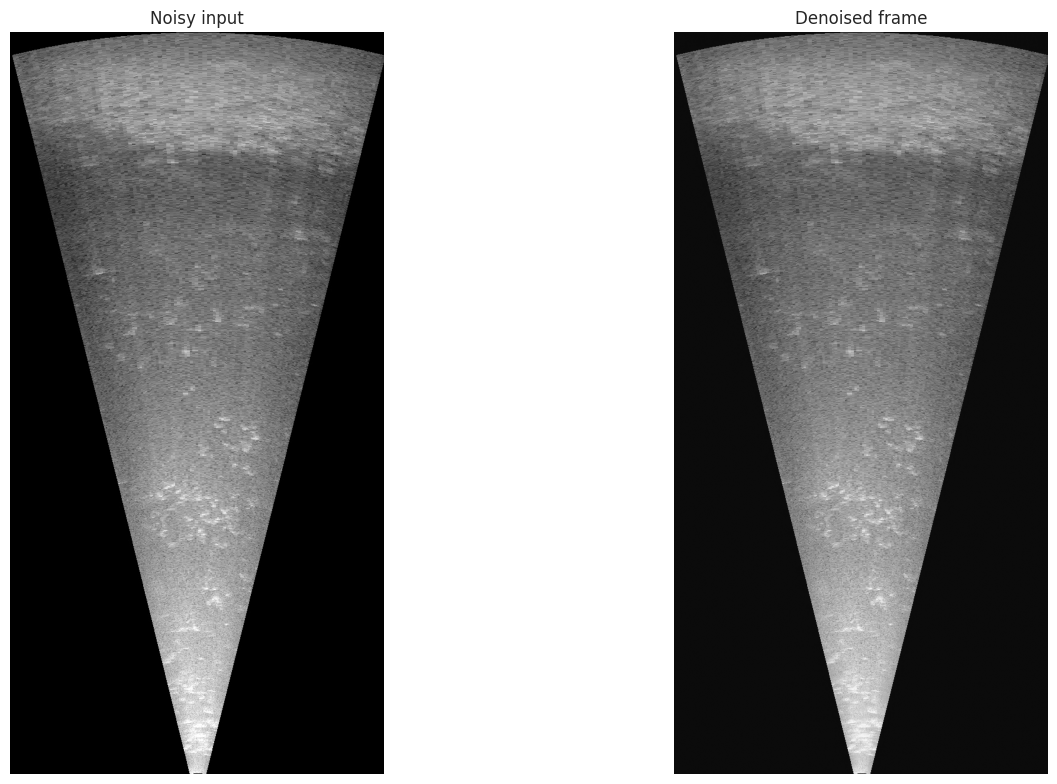

In [8]:
# plot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

print(outputs[0,0,:,:].cpu().detach().numpy().shape)
np_outputs = outputs[0,0,:,:].cpu().detach().numpy()
print(np.all(np_outputs == 0))
print(np.min(np_outputs))
print(np.max(np_outputs))

# scale np_outputs to 0-1
np_outputs = np_outputs - np.min(np_outputs)
np_outputs = np_outputs / np.max(np_outputs)


# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(16,8))


if is_image:
    ax1.imshow(noisy_inputs_with_batch[0,0,:,:].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1) 
else: # otherwise is_video
    ax1.imshow(noisy_inputs_with_batch[0,2,:,:].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1) 
ax1.set_title("Noisy input")
ax1.axis("off")

ax2.imshow(np_outputs, cmap="gray", vmin=0, vmax=1) 
ax2.set_title("Denoised frame")
ax2.axis("off")

plt.tight_layout()